## Simple Stock Market Direction Prediction

- Uses S&P 500 stock data from Yahoo Finnce 

### Install pandas-datareader if it not already installed

In [ ]:
#!pip install pandas-datareader
#!pip install tabulate
!conda update scikit-learn

### Specify the imported packages

In [5]:
from __future__ import print_function
import itertools
import datetime
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

#from pandas.io.data import DataReader
import pandas_datareader.data as web
import pandas_datareader as pdr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.metrics import confusion_matrix
from sklearn.qda import QDA
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

%matplotlib inline

# Use aternative approach to get Stock Prices from Yahoo
%run Yahoo_Stock_Prices.ipynb


ImportError: No module named 'sklearn.lda'

### Help function to source closing stock price data from Yahoo

- Data is time series based on start and end date time-window
- Prices are sourced for today
- Prices are also sourced for lagged number of days
- Prices are converted into returns
- Volumes are also sourced for each day
- Direction of returns for the current date is computed as the sign(returns)

In [3]:
def createLaggedSeries(symbol, start_date, end_date, lags=5):
    """
    This creates a pandas DataFrame that stores the 
    percentage returns of the adjusted closing value of 
    a stock obtained from Yahoo Finance, along with a 
    number of lagged returns from the prior trading days 
    (lags defaults to 5 days). Trading volume, as well as 
    the Direction from the previous day, are also included.
    """

    # Obtain stock information from Yahoo Finance
#     ts = web.DataReader(
#         symbol, "yahoo", 
#         start_date-datetime.timedelta(days=365), 
#         end_date
#     )
    #ts = pdr.get_data_yahoo(symbol, start_date, end_date)
    ts = get_historical_prices(symbol, start_date-datetime.timedelta(days=365), end_date)

    # Create the new lagged DataFrame
    tslag = pd.DataFrame(index=ts.index)
    tslag["Today"] = ts["adjclose"]
    tslag["Volume"] = ts["volume"]

    # Create the shifted lag series of prior trading period close values
    for i in range(0, lags):
        tslag["Lag%s" % str(i+1)] = ts["adjclose"].shift(i+1)

    # Create the returns DataFrame
    tsret = pd.DataFrame(index=tslag.index)
    tsret["Volume"] = tslag["Volume"]
    tsret["Today"] = tslag["Today"].pct_change()*100.0

    # If any of the values of percentage returns equal zero, set them to
    # a small number (stops issues with QDA model in scikit-learn)
    for i,x in enumerate(tsret["Today"]):
        if (abs(x) < 0.0001):
            tsret["Today"][i] = 0.0001

    # Create the lagged percentage returns columns
    for i in range(0, lags):
        tsret["Lag%s" % str(i+1)] = \
        tslag["Lag%s" % str(i+1)].pct_change()*100.0

    # Create the "Direction" column (+1 or -1) indicating an up/down day
    tsret["Direction"] = np.sign(tsret["Today"])
    #tsret = tsret[tsret.index >= start_date]

    return tsret

### Helper methods to Explore and Plot the Stock data

In [50]:
def getStockFromYahoo(symbol="^GSPC", start_date=datetime.datetime(2001,1,10),end_date=datetime.datetime(2005,12,31), lags=5):
    """
    Gets the S&P 500 Lagged stock data form Yahoo
    """
    return createLaggedSeries(symbol, start_date, end_date, lags)
    

In [51]:
def exploreData(data):
    """
    Provide Data Exploration
    """
    from tabulate import tabulate
    print("\nData Descriptive Stats:\n{}".format(tabulate(data.describe(),headers='keys', tablefmt='psql')))
    print("\nSample Data Head:\n{}".format(tabulate(data.head(), headers='keys', tablefmt='psql')))
    print("\nSample Data Tail:\n{}".format(tabulate(data.tail(), headers='keys', tablefmt='psql')))
    

In [52]:
def plotData(data, cols=['Today', 'Volume']):
    """
    Plot selective columns of the Stock data
    """
    plots = data[cols].plot(subplots=True, figsize=(10, 10))
    plt.show()
    

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Data Descriptive Stats:
+-------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|       |         Volume |        Today |         Lag1 |         Lag2 |         Lag3 |         Lag4 |         Lag5 |    Direction |
|-------+----------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------|
| count | 1502           | 1501         | 1500         | 1499         | 1498         | 1497         | 1496         | 1501         |
| mean  |    1.40566e+09 |    0.0164993 |    0.0162165 |    0.0170294 |    0.0177456 |    0.017298  |    0.0173444 |   -0.0193205 |
| std   |    3.74924e+08 |    1.18723   |    1.18757   |    1.18755   |    1.18762   |    1.18789   |    1.18829   |    1.00015   |
| min   |    3.5607e+08  |   -5.42191   |   -5.42191   |   -5.42191   |   -5.42191   |   -5.42191   |   -5.42191   |   -1         |
| 25%   |    1.15155e+09 |   -0.618451  |   -0.6185

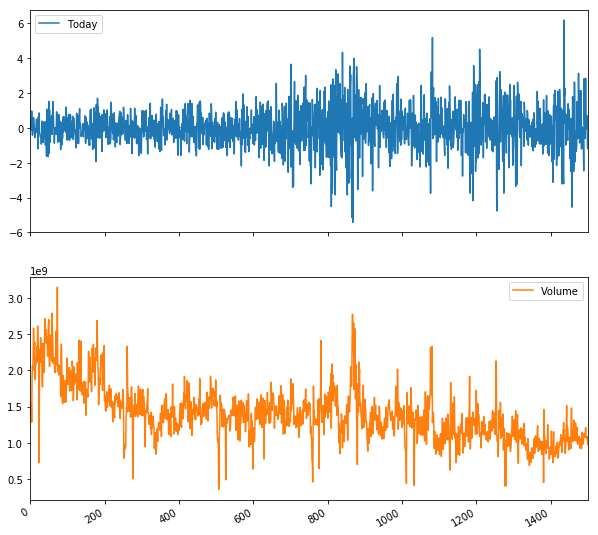

In [53]:
s_p_500_data = getStockFromYahoo()
exploreData(s_p_500_data)
plotData(s_p_500_data)

### Let us pre-process the data

In [55]:
import sklearn.preprocessing as spp
scaler = spp.StandardScaler()
n_cols = s_p_500_data.shape[1]
X = s_p_500_data[:n_cols - 1]
y = s_p_500_data[:-1]
X_scaled = scaler.fit_transform(X)
s_p_500_data_new = np.xstack(X,y )

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Split the data into Training / Test samples
- Initial prediction will be based on the features: Lag1, Lag2
- Label will be: Direction
- Training data set will be from 2001, 1, 10 to 2005, 1, 1
- Test data set will be from 2005, 1 , 1 to 2005, 12, 31

In [101]:
def splitData(data, data_cols=[["Lag1", "Lag2"], "Direction"], split_point=datetime.datetime(2005,1,1)):
    """
    Specifies the feature and label cols and also splits the data into training/test sets
    """
    X = data[data_cols[0]]
    y = data[data_cols[1]]
    
    # Create training and test sets
    X_train = X[X.index < split_point]
    X_test = X[X.index >= split_point]
    y_train = y[y.index < split_point]
    y_test = y[y.index >= split_point]
    split_data = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }
    return split_data
    
    

### Apply ensemble of ML classifier models and observe the confusion matrix and accuracy 

In [108]:
def runClassifierModels(data):
    """
    Create and run an esemble of ML classifier models against the data and predit the return direction of the stocks
    """
    print("Hit Rates/Confusion Matrices:\n")
    models = [("LR", LogisticRegression()), 
              ("LDA", LDA()), 
              ("QDA", QDA()),
              ("LSVC", LinearSVC()),
              ("RSVM", SVC(
              	C=1000000.0, cache_size=200, class_weight=None,
                coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
                max_iter=-1, probability=False, random_state=None,
                shrinking=True, tol=0.001, verbose=False)
              ),
              ("RF", RandomForestClassifier(
              	n_estimators=1000, criterion='gini', 
                max_depth=None, min_samples_split=2, 
                min_samples_leaf=1, max_features='auto', 
                bootstrap=True, oob_score=False, n_jobs=1, 
                random_state=None, verbose=0)
              ),
              ("MPL",MLPClassifier(solver='lbfgs', alpha=1e-5,
                hidden_layer_sizes=(10,5), random_state=1))
             ]

    # Iterate through the models
    for m in models:
        
        # Train each of the models on the training set
        m[1].fit(data["X_train"], data["y_train"])

        # Make an array of predictions on the test set
        pred = m[1].predict(data["X_test"])

        # Output the hit-rate and the confusion matrix for each model
        print("Accuracy for Model [{0}] : {1}".format(m[0], m[1].score(data["X_test"], data["y_test"])))
        print("Confusion Matrix: \n{}".format(confusion_matrix(pred, data["y_test"])))
            

In [109]:
split_data = splitData(s_p_500_data)
# print(split_data["X_test"].shape)
# print(split_data["y_test"].shape)
runClassifierModels(split_data)

Hit Rates/Confusion Matrices:

Accuracy for Model [LR] : 0.559523809524
Confusion Matrix: 
[[ 35  35]
 [ 76 106]]
Accuracy for Model [LDA] : 0.559523809524
Confusion Matrix: 
[[ 35  35]
 [ 76 106]]
Accuracy for Model [QDA] : 0.599206349206
Confusion Matrix: 
[[ 30  20]
 [ 81 121]]
Accuracy for Model [LSVC] : 0.559523809524
Confusion Matrix: 
[[ 35  35]
 [ 76 106]]
Accuracy for Model [RSVM] : 0.575396825397
Confusion Matrix: 
[[  8   4]
 [103 137]]
Accuracy for Model [RF] : 0.507936507937
Confusion Matrix: 
[[48 61]
 [63 80]]
Accuracy for Model [MPL] : 0.539682539683
Confusion Matrix: 
[[48 53]
 [63 88]]


In [35]:
# import pandas_datareader as pdr

# import datetime

# start = datetime.datetime(2018,1,1)

# end = datetime.date.today()

# baba = pdr.get_data_yahoo('BABA', start, end)

# baba
%run Yahoo_Stock_Prices.ipynb
import datetime

# Get IBM's stock prices for 2017/1/1 - current date
df_stocks = get_historical_prices(ticker="IBM",
                                                                 start_date=datetime.datetime(2017,1,1),
                                                                 end_date=datetime.datetime.now())

df_stocks.head()

,adjclose,close,date,high,low,open,volume
0,152.089996,152.089996,2018-03-22,155.249893,152.000000,155.000000,4742352
1,156.690002,156.690002,2018-03-21,158.199997,155.919998,156.570007,3240700
2,156.199997,156.199997,2018-03-20,157.929993,155.289993,157.520004,4336700
3,157.350006,157.350006,2018-03-19,159.889999,156.449997,159.710007,5482000
4,160.259995,160.259995,2018-03-16,161.979996,159.639999,160.059998,9262700
